In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb

In [ ]:
# ==========================
# 1. Load Data
# ==========================
df = pd.read_excel("Solardata_final_1.xlsx", parse_dates=["Date and Time"])

target = "Output Power (kW)"

In [ ]:
# ==========================
# 2. Preprocessing & Feature Engineering
# ==========================
# Fault flag (1=fault, 0=ok)
df["fault_flag"] = df["Grid side or other fault"].notnull().astype(int)

In [ ]:
# Handle nighttime (GHI/POA ~ 0 at night)
df.loc[df["Night Time or no generation detection"] == 1, ["GHI (W/m²)", "POA (W/m²)"]] = 0

In [ ]:
# Time features
df["hour"] = df["Date and Time"].dt.hour
df["dayofweek"] = df["Date and Time"].dt.dayofweek
df["month"] = df["Date and Time"].dt.month
df["is_daytime"] = df["hour"].between(6, 18).astype(int)

In [ ]:
# Cyclical encoding for daily/seasonal cycles
df["Seconds"] = df["Date and Time"].map(pd.Timestamp.timestamp)
day = 60 * 60 * 24
year = 365.2425 * day
df["DaySin"] = np.sin(df["Seconds"] * (2 * np.pi / day))
df["DayCos"] = np.cos(df["Seconds"] * (2 * np.pi / day))
df["YearSin"] = np.sin(df["Seconds"] * (2 * np.pi / year))
df["YearCos"] = np.cos(df["Seconds"] * (2 * np.pi / year))
df.drop(columns = ["Seconds"], inplace = True)

In [ ]:
# Lag features (persistence)
df["lag_1"] = df[target].shift(1)
df["lag_48"] = df[target].shift(48)  # same time yesterday (if half-hour data)
df["rolling_3"] = df[target].shift(1).rolling(window=3).mean()
df["rolling_24"] = df[target].shift(1).rolling(window=24).mean()

df.dropna(inplace=True)  # drop first rows with NaNs from lags

In [ ]:
# ==========================
# 3. Feature / Target Split
# ==========================
X = df.drop(columns=[ "SL No.", "Date and Time", target, "Grid side or other fault", "Night Time or no generation detection" ])
y = df[target]

In [ ]:
# ==========================
# 4. Train-Test Split (time-based)
# ==========================
split_index = int(len(df) * 0.8)  # 80% train, 20% test
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

In [ ]:
# ==========================
# 5. XGBoost Model (Baseline)
# ==========================
model = xgb.XGBRegressor(
    n_estimators  = 500,
    learning_rate = 0.1,
    max_depth = 6,
    subsample = 0.8,
    colsample_bytree  = 0.8,
    random_state  = 42,
    n_jobs  = -1
)

model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=-1, num_parallel_tree=None, ...)

In [ ]:
# ==========================
# 6. Evaluation
# ==========================
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / (y_test + 1e-5))) * 100  # avoid div/0

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")

MAE: 31.60
RMSE: 78.55
R²: 0.9999
MAPE: 19063680.59%


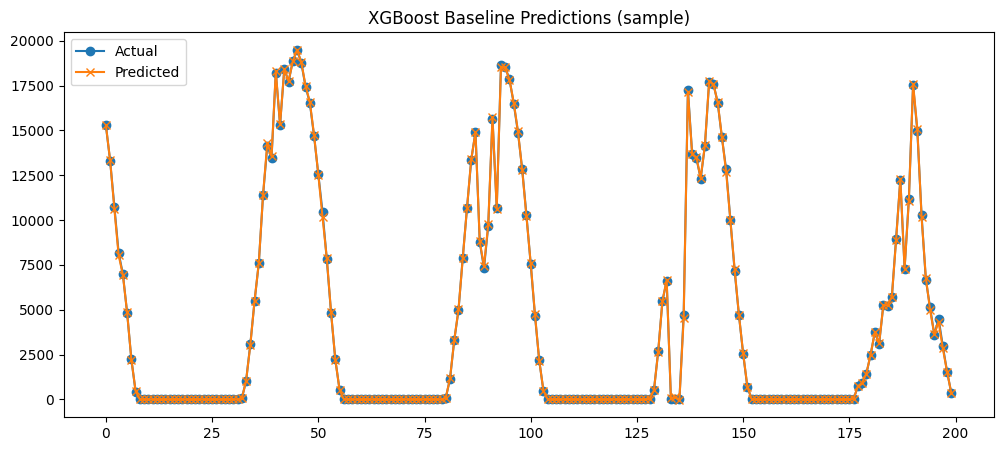

In [ ]:
# ==========================
# 7. Plot Results
# ==========================
plt.figure(figsize=(12,5))
plt.plot(y_test.values[:200], label="Actual", marker="o")
plt.plot(y_pred[:200], label="Predicted", marker="x")
plt.title("XGBoost Baseline Predictions (sample)")
plt.legend()
plt.show()

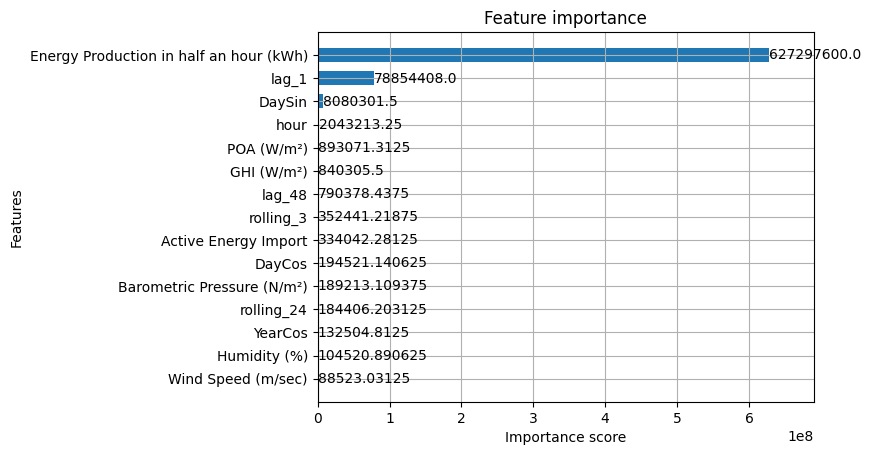

In [ ]:
# ==========================
# 8. Feature Importance
# ==========================
xgb.plot_importance(model, importance_type="gain", max_num_features=15, height=0.6)
plt.show()